# 3.2. Friction Distribution between twisted Spiral Torus

前の章で螺旋トーラスと球体の接触位置と荷重は確認できたので，次のステップはクーロン摩擦の分布を調べる．なお，この章では螺旋トーラスは剛体として扱う．接触部のみ弾性体である．


## 3.2.1. 摩擦モデルの比較

|                      |      US     |     JP    |
|:--------------------:|:-----------:|:---------:|
|    Representative    | S2A, Timken |  NSK, NTN |
|     Totalization     | Integration $ \int $ ![Asset1](Asset1.svg)| Summation $ \sum $ ![Asset2](Asset2.svg)|
| contact condition |  ellipse       |   line (approximate)     |
|         Merit        |     楕円短径方向の分布を考慮できる <br> 値の不連続が起きにくい <br> クーロン摩擦との相性がいい  <br> （事前準備をしておけば）計算速度は速い      <br> ハイパーパラメタ（メッシュ数）がない  |       モデルの適応範囲が広い <br> 様々な摩擦モデルを取り入れ易い    |
|         Demerit      |     モデル毎に事前計算が必要 <br> クーロン摩擦以外との適合性が悪い？        |    楕円短径方向の分布を無視してしまう <br> 値の不連続が起きやすい   <br> メッシュが細かいほど計算時間が遅くなる     |
| friction coefficient | Simple Coulomb <br> ![Coulomb](Coulomb.jpg)| Smooth Coulomb　<br> ![Smooth_Coulomb](Smooth_Coulomb.jpg)  |

今回は，単純クーロン摩擦で扱う．理由は以下の通りである．
- 取り扱いがシンプルである．
- ボールねじは表面粗さが大きく，油膜が出来にくい．
- （This is a chicken or egg situation, but...）ボールねじは滑り速度が大きいので，どのモデルを使ったとしても摩擦係数は一定であることが多いはず？
- 玉一個なので，厳密に計算しても時間はかからない．フルモデルの場合では，もう少し簡素化が必要．
- 面積分を行うため，値の不連続性が発生し難い．（線積分では値の不連続が問題になる場合がある）
- 単純に勉強のためにやってみたかった．



In [1]:
%config InlineBackend.figure_format = "svg"


In [2]:
import numpy as np
from matplotlib import pyplot as plt


In [3]:
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


直交座標系で圧力分布を調べる．

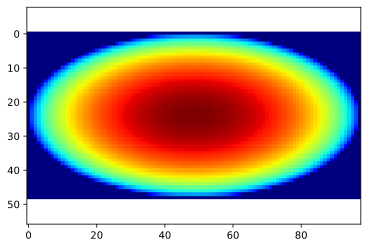

In [4]:
n = 49
x = np.linspace(-1.0, 1.0, 2 * n)
y = np.linspace(-1.0, 1.0, n)
x_, y_ = np.meshgrid(x, y)
Psq = 1.0 - np.square(x_) - np.square(y_)
Psq[Psq<0.0] = 0.0
P = np.sqrt(Psq)

plt.imshow(P, cmap=plt.cm.jet)
plt.axis('equal')
plt.show()


![NTN1](NTN1.jpg)
![NTN2](NTN2.jpg)

99x99のメッシュの総和と，NTNが提唱している式とを比較する．


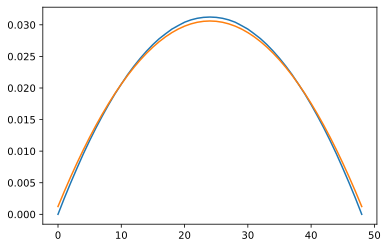

In [5]:
SFR = TB.SliceForceRatio(n)

plt.plot(P.sum(1) / P.sum())
plt.plot(SFR)


直交座標系では，接触していない場所にもメッシュが存在してしまうため非効率である．そのため，極座標系へ置き換える．

$$
P(x, y) = P_{\text{max}} \sqrt{1 - \frac{x^2}{a^2} - \frac{y^2}{b^2}}
$$
_
$$
\left( -a \leq x \leq a, -b \leq y \leq b \right)
$$
_
$$
x = ar \cos{\theta}, y = br \sin{\theta}
$$
_
$$
\left( 0 \leq r \leq 1, 0 \leq \theta \leq 2\pi \right)
$$
_
$$
P(r, \theta) = P_{\text{max}} \sqrt{1 - r^2}
$$


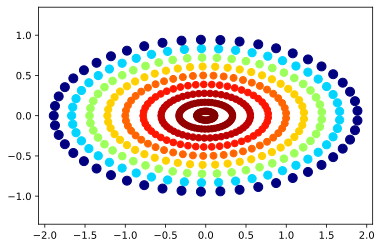

In [6]:
n = 49
r = (np.arange(int(n/5)) + 0.5) / int(n/5)
t = (np.arange(n) + 0.5) / n * 2 * np.pi

r_, t_ = np.meshgrid(r, t)
x_ = r_ * np.cos(t_) * 2.0 # = a 
y_ = r_ * np.sin(t_) * 1.0 # = b
F_ = np.sqrt(1 - np.square(r_))

plt.scatter(x_, y_, c=F_, cmap=plt.cm.jet, s=100*(1-F_*0.6))
plt.axis('equal')
plt.show()


$$
\begin{eqnarray*}
\text{d} F &=& P \cdot \text{d} S \\
&=& P(r, \theta) \cdot ab \cdot r \text{d} \theta \text{d} r \\
&=& P_{\text{max}} ab \cdot r \sqrt{1 - r^2} \cdot \text{d} \theta \text{d} r \\
&=& \frac{3F}{2 \pi} \cdot r \sqrt{1 - r^2} \cdot \text{d} \theta \text{d} r \\
\end{eqnarray*}
$$

_

$$
\begin{eqnarray*}
\int^{\theta_1}_{\theta_0} \int^{r_1}_{r_0} \text{d} F &=& \frac{3F}{2 \pi}(\theta_1 - \theta_0) \int^{r_1}_{r_0} r \sqrt{1 - r^2} \text{d} r \\
&=& \frac{3F}{2 \pi}(\theta_1 - \theta_0) \left[ -\frac{1}{3} (1 - x^2)^{1.5} \right]^{r_1}_{r_0} \\
\end{eqnarray*}
$$


In [7]:
dt = t[1] - t[0]
r_node = np.linspace(0., 1., int(n/5+1))
Antiderivative = lambda x: -(1-x*x)**1.5 / 2 / np.pi
ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt

r_, t_ = np.meshgrid(r, t)
ratio, t_ = np.meshgrid(ratio_dt, t)
ratio.sum()

1.0

## 3.2.2. 動解析を使って摩擦の釣り合いを観察する

まずはパラメタの設定．


In [8]:
R = 6.35 / 2
Rg = R * 1.08
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
mu = 0.10

r_mesh = r_.reshape(-1)
t_mesh = t_.reshape(-1)
ratio_mesh = ratio.reshape(-1)
x_mesh = r_mesh * np.cos(t_mesh)
y_mesh = r_mesh * np.sin(t_mesh)


$$
\frac{\text{d}}{\text{d}t}\begin{pmatrix} x \\ v \\ \omega \end{pmatrix} 
= \begin{pmatrix} v \\ F/m \\ T/I \end{pmatrix}
$$
_
$$
\begin{eqnarray*}
u_* &=& v_* + \omega_* \times (p - x_*) \\
\Delta u &=& u_{\text{groove}} - u_{\text{ball}} \\
\end{eqnarray*}
$$
_
$$
\begin{eqnarray*}
F &=& \sum_{\text{spiral}}^{\text{nut, shaft}} \sum_{\text{groove}}^{\text{left, right}} \left( Hertzian  + \int_{\theta} \int_{r} \frac{\Delta u}{|\Delta u|} \mu \text{d}F \right) \\
T &=& \sum_{\text{spiral}}^{\text{nut, shaft}} \sum_{\text{groove}}^{\text{left, right}} \left(\int_{\theta} \int_{r} \frac{\Delta u}{|\Delta u|} \times R \cdot \mu \text{d}F \right)
\end{eqnarray*}
$$


In [29]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def vFmTI_ball(xvw_ball, t, mode):
    
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    
    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    v_eta = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                
                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                
                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                
    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    
    if mode == 1:
        return a_, b_, a_dir, b_dir, dv

    if mode == 2:
        return a_, b_, a_dir, b_dir, muF, F_norm
    
    if mode == 3:
        return v_eta
    
    return np.concatenate([v_ball, Fm_ball, TI_ball])


In [10]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])


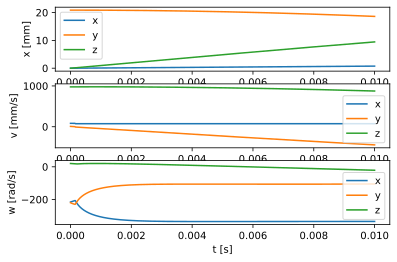

In [11]:
from scipy.integrate import odeint
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[0].set_ylabel('x [mm]')
ax[0].legend(['x', 'y', 'z'])

ax[1].plot(t[:], sol[:, 3:6])
ax[1].set_ylabel('v [mm/s]')
ax[1].legend(['x', 'y', 'z'])

ax[2].plot(t[:], sol[:, 6:9])
ax[2].set_ylabel('w [rad/s]')
ax[2].legend(['x', 'y', 'z'])
ax[2].set_xlabel('t [s]')

plt.show()


一応，念のため定常状態か確認する．vおよびwのx成分が一定であれば定常状態である．

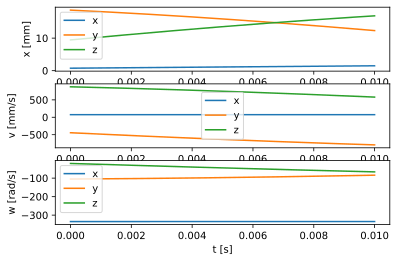

In [12]:
xvw_ball = sol[-1, :]

sol_check = odeint(vFmTI_ball, xvw_ball, t, args=(0,))
fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol_check[:, 0:3])
ax[0].set_ylabel('x [mm]')
ax[0].legend(['x', 'y', 'z'])

ax[1].plot(t[:], sol_check[:, 3:6])
ax[1].set_ylabel('v [mm/s]')
ax[1].legend(['x', 'y', 'z'])

ax[2].plot(t[:], sol_check[:, 6:9])
ax[2].set_ylabel('w [rad/s]')
ax[2].legend(['x', 'y', 'z'])
ax[2].set_xlabel('t [s]')

plt.show()

## 3.2.3. 定常状態の確認

各パラメタを詳らかに観察する．


In [13]:
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

def plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, dv_unit):
    # Defining subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=300)

    # Creating plot
    a_max = a_.max()
    b_max = b_.max()

    for iSP in range(2):
        for i in range(2):
            a_mesh00 = a_[iSP,i] * x_mesh
            b_mesh00 = b_[iSP,i] * y_mesh

            dvx00 = dv[iSP,i,:,:].dot(a_dir[iSP,i,:])
            dvy00 = dv[iSP,i,:,:].dot(b_dir[iSP,:])

            dv_norm = np.sqrt(np.square(dvx00) + np.square(dvy00))

            ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
            quiver = ax[iSP, i].quiver(a_mesh00, b_mesh00, dvx00, dvy00, dv_norm, cmap='jet')
            ax[iSP, i].add_patch(ellipse)
            ax[iSP, i].set_aspect('equal')
            ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
            ax[iSP, i].spines['right'].set_visible(False)
            ax[iSP, i].spines['top'].set_visible(False)
            ax[iSP, i].spines['left'].set_visible(False)
            ax[iSP, i].spines['bottom'].set_visible(False)
            ax[iSP, i].yaxis.set_ticks([])
            ax[iSP, i].set_xlabel('x [mm]')
            colorbar = fig.colorbar(quiver, ax=ax[iSP, i])
            colorbar.ax.set_title(dv_unit)
            
    return fig, ax


### 3.2.3.1. Start Condition (Artificial setting)


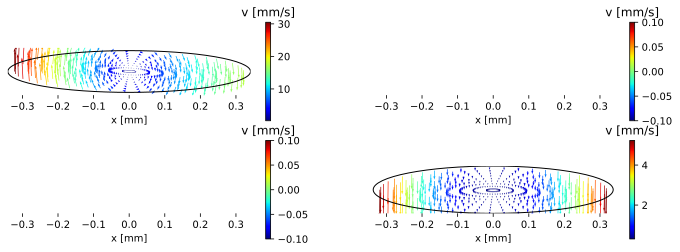

In [14]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[0, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


### 3.2.3.2. Right before the collision


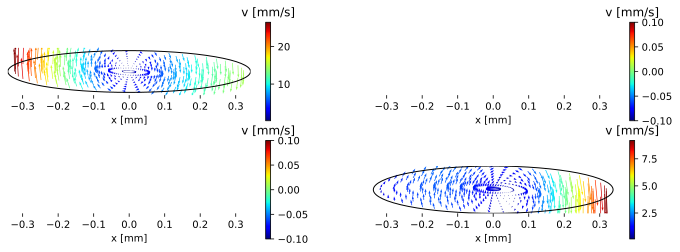

In [15]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[15, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


### 3.2.3.3. Right after the collision


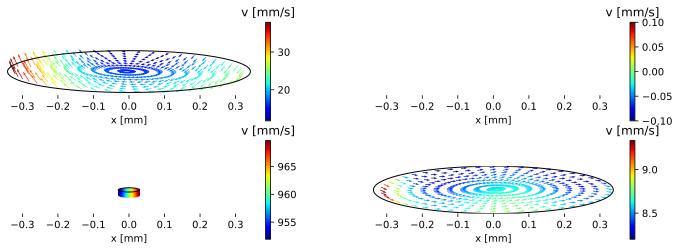

In [16]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[20, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


### 3.2.3.4 Steady State


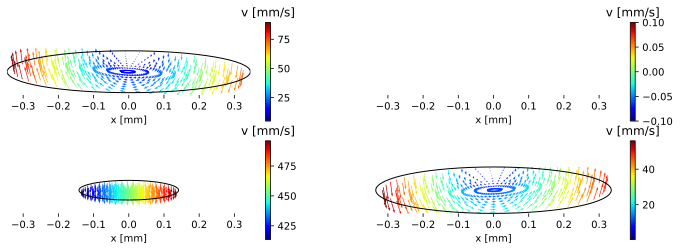

In [17]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


In [18]:
import pandas as pd

def plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm):
    muF_table = pd.DataFrame(columns=['S/N', 'L/R', 'muFx [N]', 'muFy [N]', 'Fz [N]'])

    # Defining subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=300)

    # Creating plot
    a_max = a_.max()
    b_max = b_.max()

    for iSP in range(2):
        for i in range(2):
            a_mesh00 = a_[iSP,i] * x_mesh
            b_mesh00 = b_[iSP,i] * y_mesh

            muFx_sum = np.array([muF[iSP,i,:,:].T.dot(a_dir[iSP,i,:]).sum(), 0.0])
            muFy_sum = np.array([0.0, muF[iSP,i,:,:].T.dot(b_dir[iSP,:]).sum()])
            muF_table = muF_table.append({'S/N':str(iSP), 'L/R':str(i), 'muFx [N]':(muFx_sum + muFy_sum)[0], 'muFy [N]':(muFx_sum + muFy_sum)[1], 'Fz [N]':F_norm[iSP,i]}, ignore_index=True)

            ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
            quiver = ax[iSP, i].quiver([0.0, 0.0], [0.0, 0.0], muFx_sum, muFy_sum, scale=5)

            ax[iSP, i].add_patch(ellipse)
            ax[iSP, i].set_aspect('equal')
            ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
            ax[iSP, i].spines['right'].set_visible(False)
            ax[iSP, i].spines['top'].set_visible(False)
            ax[iSP, i].spines['left'].set_visible(False)
            ax[iSP, i].spines['bottom'].set_visible(False)
            ax[iSP, i].yaxis.set_ticks([])
            ax[iSP, i].set_xlabel('x [mm]')
            
    return fig, ax, muF_table


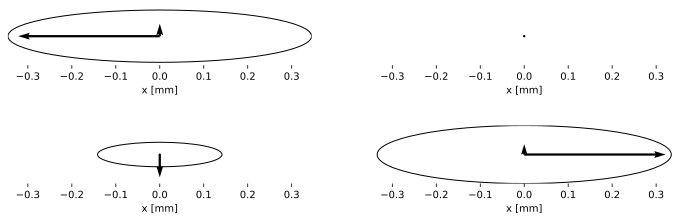

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0 -2.329602  0.204453  52.095306
1   0   1  0.000000  0.000000   0.000000
2   1   0  0.008739 -0.375962   3.760815
3   1   1  2.328381  0.170758  51.686999


In [19]:
a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)


In [20]:
v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


[[ 9.83936627e+02 -1.84544728e-02 -2.76860265e-03]
 [ 9.83936627e+02  1.33584949e-03 -2.76861577e-03]]


予想通りだったこと
- 進行方向で，3点目は純粋に進行方向に滑っている．
- 進行方向で，3点目の総和でみた摩擦係数は$\mu$は，入力の0.10とほぼ等しくなっている．
- 進行方向で，1,2点目の摩擦の和と3点目の摩擦は打ち消し合う．
- 定常状態の速度方向は，2点当たりする側に拘束される．

納得いかないこと
- 1,2点目の摩擦がほぼ同じ大きさとなっている．
- 1,2点目の摩擦の総和でみた摩擦係数は$\mu$は，入力の0.10より小さい約0.05になっている．
- 壁面方向で，1,2点目の摩擦の和が3点目の垂直抗力に釣り合わない．（接触角の違いのせい？）


## 逆回転では？


In [21]:
rpm = -1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))


### 3.2.*.* Steady State


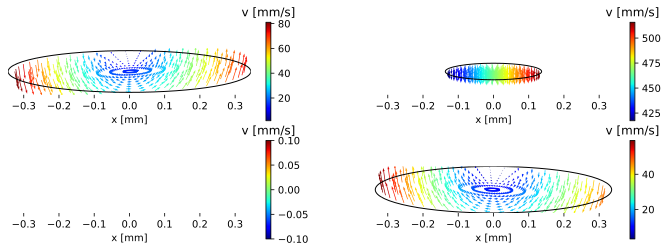

In [22]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


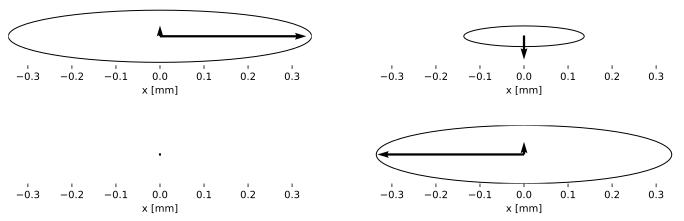

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0  2.412387  0.176081  52.760390
1   0   1  0.012127 -0.385420   3.856310
2   1   0  0.000000  0.000000   0.000000
3   1   1 -2.416924  0.208572  53.249741


In [23]:
a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)


In [24]:
v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


[[-9.76068329e+02  6.90480444e-03 -8.15586012e-03]
 [-9.76068329e+02 -1.27302767e-02 -8.15586459e-03]]


### まだ残っている問題（初期値）

F: 3
T: 3

x: 2
v: 1
w: 3

壁に押し付ける（0.5μNにする？）．
v, w の初期値は？
これを知りたい！

v, w じゃない何か指標が欲しいのかも
なんか別のパラメタに置き換えられないかな

v,w の範囲は狭いはず．
特に，摩擦が μN になる範囲はグッと狭いはず．

あ，つまり純転がり + 何か別の回転なのでは？

回転数0で表面の滑りを見ればよいのでは？

いや，違うわ．接触楕円内（近傍）に回転軸があればええんや．

どっちの側の方が中心にありやすいか見た方がいいかもね．
それができれば，回転軸中心投影点の a, b パラメタで整理できるかも．

ちょうど v: 1, w:3 で 4自由度なので，Pivot をそれぞれ両面で a, b 2つずつ使えばいいかもかも．

45度のときには何で3つ目のPivotが出てこんのやろね？40-55のときには出てくるのに．
幾何学的に成立しない（しにくい）のかな？

そもそもPivotが出来る条件てなんやろね？教授に聞いた方がええかな？

Pivot=純転がり点だと思う

40-55だと3つ全部渦になっとるね

Pivotを落とす式が知りたい！

まあ何はともあれ主荷重2点のPivotは楕円付近てのは間違いないだろうね


## NSKの新規開発品の評価

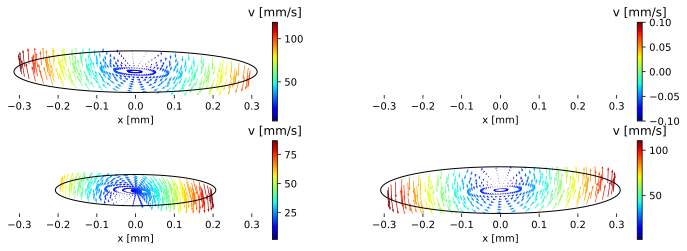

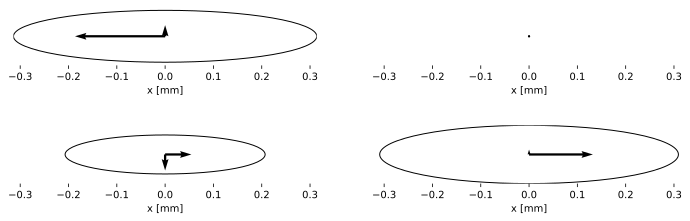

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0 -1.485937  0.183430  38.791275
1   0   1  0.000000  0.000000   0.000000
2   1   0  0.433572 -0.264298  12.152944
3   1   1  1.052816  0.080292  40.673982
[[ 8.43085316e+02 -1.80119230e-02 -1.19158070e-03]
 [ 8.43085316e+02 -1.05497901e-03 -1.19159532e-03]]


In [25]:
ts = 40
tn = 55
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')

a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)

v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


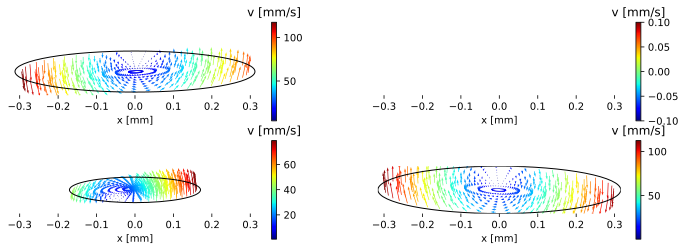

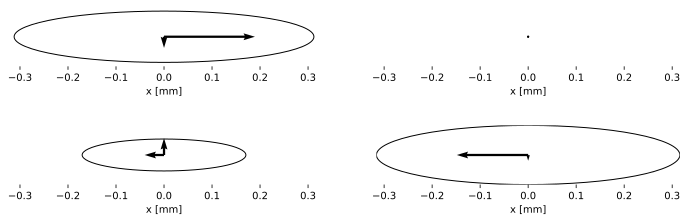

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0  1.497930 -0.183986  40.499654
1   0   1  0.000000  0.000000   0.000000
2   1   0 -0.320662  0.277666   7.484167
3   1   1 -1.177396 -0.094310  42.825196
[[-8.42689240e+02  1.17437723e-02  1.06040661e-02]
 [-8.42689240e+02 -5.20533510e-03  1.06040711e-02]]


In [26]:
rpm = -1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')

a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)

v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


### 評価まとめ

- 意外と3点全てで純転がり（Pivot）が発生している！
- 正/逆回転で玉の進行方向ベクトルが並行である？（2点側で制御している？）


## もしゴシックアーチでなければ



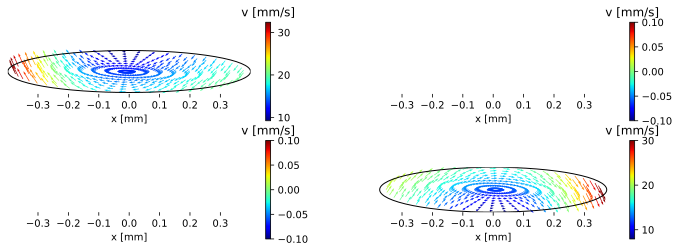

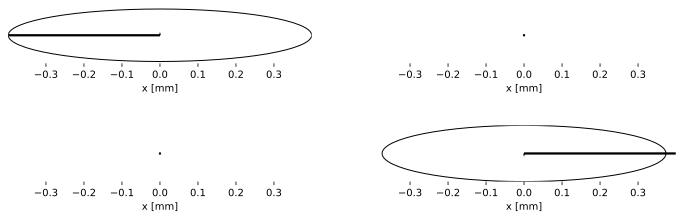

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0 -5.163735  0.053457  76.560282
1   0   1  0.000000  0.000000   0.000000
2   1   0  0.000000  0.000000   0.000000
3   1   1  5.179807 -0.054541  76.640958
[[ 9.80139429e+02 -5.31310955e-02 -4.31499776e-02]
 [ 9.80139430e+02 -3.34270863e-02 -4.31500439e-02]]


In [31]:
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, 2*Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([2*Rg, Rg]))
SP12 = [SP1, SP2]

rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')

a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)

v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)
